# Setting up spark dependencies

In [1]:
from pyspark.context import SparkContext
from pyspark.sql.context import SQLContext
from pyspark.sql.session import SparkSession
    
sc = SparkContext()
sqlContext = SQLContext(sc)
spark = SparkSession(sc)

# load up other dependencies
import re
import pandas as pd

D:\project\lib\site-packages\pyspark\sql\context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [2]:
m = re.finditer(r'.*?(spark).*?', "I'm searching for a spark in PySpark", re.I)
for match in m:
    print(match, match.start(), match.end())

<re.Match object; span=(0, 25), match="I'm searching for a spark"> 0 25
<re.Match object; span=(25, 36), match=' in PySpark'> 25 36


# Loading and Viewing the dataset

In [3]:
import glob

raw_data_files = glob.glob('*.1txt')
raw_data_files

['log1.1txt']

In [4]:
base_df = spark.read.text(raw_data_files)
base_df.printSchema()

root
 |-- value: string (nullable = true)



In [5]:
type(base_df)

pyspark.sql.dataframe.DataFrame

# Converting into RDD

In [6]:
base_df_rdd = base_df.rdd
type(base_df_rdd)

pyspark.rdd.RDD

# Displaying the log file

In [7]:
base_df.show(10, truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------+
|value                                                                                                                                                    |
+---------------------------------------------------------------------------------------------------------------------------------------------------------+
|64.242.88.10 - - [07/Mar/2004:16:05:49 -0800] "GET /twiki/bin/edit/Main/Double_bounce_sender?topicparent=Main.ConfigurationVariables HTTP/1.1" 401 12846 |
|64.242.88.10 - - [07/Mar/2004:16:06:51 -0800] "GET /twiki/bin/rdiff/TWiki/NewUserTemplate?rev1=1.3&rev2=1.2 HTTP/1.1" 200 4523                           |
|64.242.88.10 - - [07/Mar/2004:16:10:02 -0800] "GET /mailman/listinfo/hsdivision HTTP/1.1" 200 6291                                                       |
|64.242.88.10 - - [07/Mar/2004:16:11:58 -0800] "GET /twiki/bin/v

# Number of total logs in dataset

In [8]:
print((base_df.count(), len(base_df.columns)))

(1546, 1)


In [9]:
sample_logs = [item['value'] for item in base_df.take(15)]
sample_logs

['64.242.88.10 - - [07/Mar/2004:16:05:49 -0800] "GET /twiki/bin/edit/Main/Double_bounce_sender?topicparent=Main.ConfigurationVariables HTTP/1.1" 401 12846',
 '64.242.88.10 - - [07/Mar/2004:16:06:51 -0800] "GET /twiki/bin/rdiff/TWiki/NewUserTemplate?rev1=1.3&rev2=1.2 HTTP/1.1" 200 4523',
 '64.242.88.10 - - [07/Mar/2004:16:10:02 -0800] "GET /mailman/listinfo/hsdivision HTTP/1.1" 200 6291',
 '64.242.88.10 - - [07/Mar/2004:16:11:58 -0800] "GET /twiki/bin/view/TWiki/WikiSyntax HTTP/1.1" 200 7352',
 '64.242.88.10 - - [07/Mar/2004:16:20:55 -0800] "GET /twiki/bin/view/Main/DCCAndPostFix HTTP/1.1" 200 5253',
 '64.242.88.10 - - [07/Mar/2004:16:23:12 -0800] "GET /twiki/bin/oops/TWiki/AppendixFileSystem?template=oopsmore&param1=1.12&param2=1.12 HTTP/1.1" 200 11382',
 '64.242.88.10 - - [07/Mar/2004:16:24:16 -0800] "GET /twiki/bin/view/Main/PeterThoeny HTTP/1.1" 200 4924',
 '64.242.88.10 - - [07/Mar/2004:16:29:16 -0800] "GET /twiki/bin/edit/Main/Header_checks?topicparent=Main.ConfigurationVariables 

# Extracting host names/code

In [10]:
host_pattern = r'(^\S+\.[\S+\.]+\S+)\s'
hosts = [re.search(host_pattern, item).group(1)
           if re.search(host_pattern, item)
           else 'no match'
           for item in sample_logs]
hosts

['64.242.88.10',
 '64.242.88.10',
 '64.242.88.10',
 '64.242.88.10',
 '64.242.88.10',
 '64.242.88.10',
 '64.242.88.10',
 '64.242.88.10',
 '64.242.88.10',
 '64.242.88.10',
 '64.242.88.10',
 '64.242.88.10',
 '64.242.88.10',
 '64.242.88.10',
 '64.242.88.10']

# Extracting time stamps

In [11]:
ts_pattern = r'\[(\d{2}/\w{3}/\d{4}:\d{2}:\d{2}:\d{2} -\d{4})]'
timestamps = [re.search(ts_pattern, item).group(1) for item in sample_logs]
timestamps

['07/Mar/2004:16:05:49 -0800',
 '07/Mar/2004:16:06:51 -0800',
 '07/Mar/2004:16:10:02 -0800',
 '07/Mar/2004:16:11:58 -0800',
 '07/Mar/2004:16:20:55 -0800',
 '07/Mar/2004:16:23:12 -0800',
 '07/Mar/2004:16:24:16 -0800',
 '07/Mar/2004:16:29:16 -0800',
 '07/Mar/2004:16:30:29 -0800',
 '07/Mar/2004:16:31:48 -0800',
 '07/Mar/2004:16:32:50 -0800',
 '07/Mar/2004:16:33:53 -0800',
 '07/Mar/2004:16:35:19 -0800',
 '07/Mar/2004:16:36:22 -0800',
 '07/Mar/2004:16:37:27 -0800']

# Extracting https method,URIs and Protocol

In [12]:
method_uri_protocol_pattern = r'\"(\S+)\s(\S+)\s*(\S*)\"'
method_uri_protocol = [re.search(method_uri_protocol_pattern, item).groups()
               if re.search(method_uri_protocol_pattern, item)
               else 'no match'
              for item in sample_logs]
method_uri_protocol

[('GET',
  '/twiki/bin/edit/Main/Double_bounce_sender?topicparent=Main.ConfigurationVariables',
  'HTTP/1.1'),
 ('GET',
  '/twiki/bin/rdiff/TWiki/NewUserTemplate?rev1=1.3&rev2=1.2',
  'HTTP/1.1'),
 ('GET', '/mailman/listinfo/hsdivision', 'HTTP/1.1'),
 ('GET', '/twiki/bin/view/TWiki/WikiSyntax', 'HTTP/1.1'),
 ('GET', '/twiki/bin/view/Main/DCCAndPostFix', 'HTTP/1.1'),
 ('GET',
  '/twiki/bin/oops/TWiki/AppendixFileSystem?template=oopsmore&param1=1.12&param2=1.12',
  'HTTP/1.1'),
 ('GET', '/twiki/bin/view/Main/PeterThoeny', 'HTTP/1.1'),
 ('GET',
  '/twiki/bin/edit/Main/Header_checks?topicparent=Main.ConfigurationVariables',
  'HTTP/1.1'),
 ('GET', '/twiki/bin/attach/Main/OfficeLocations', 'HTTP/1.1'),
 ('GET', '/twiki/bin/view/TWiki/WebTopicEditTemplate', 'HTTP/1.1'),
 ('GET', '/twiki/bin/view/Main/WebChanges', 'HTTP/1.1'),
 ('GET',
  '/twiki/bin/edit/Main/Smtpd_etrn_restrictions?topicparent=Main.ConfigurationVariables',
  'HTTP/1.1'),
 ('GET', '/mailman/listinfo/business', 'HTTP/1.1'),
 (

# Extracting http status code

In [13]:
status_pattern = r'\s(\d{3})\s'
status = [re.search(status_pattern, item).group(1) for item in sample_logs]
print(status)

['401', '200', '200', '200', '200', '200', '200', '401', '401', '200', '200', '401', '200', '200', '200']


# Extracting HTTP Response Content Size

In [14]:
content_size_pattern = r'\s(\d+)$'
content_size = [re.search(content_size_pattern, item).group(1) for item in sample_logs]
print(content_size)

['12846', '4523', '6291', '7352', '5253', '11382', '4924', '12851', '12851', '3732', '40520', '12851', '6379', '46373', '4140']


# Putting it all in log format

In [15]:
from pyspark.sql.functions import regexp_extract

logs_df = base_df.select(regexp_extract('value', host_pattern, 1).alias('host'),
                         regexp_extract('value', ts_pattern, 1).alias('timestamp'),
                         regexp_extract('value', method_uri_protocol_pattern, 1).alias('method'),
                         regexp_extract('value', method_uri_protocol_pattern, 2).alias('endpoint'),
                         regexp_extract('value', method_uri_protocol_pattern, 3).alias('protocol'),
                         regexp_extract('value', status_pattern, 1).cast('integer').alias('status'),
                         regexp_extract('value', content_size_pattern, 1).cast('integer').alias('content_size'))
logs_df.show(10, truncate=True)
print((logs_df.count(), len(logs_df.columns)))

+------------+--------------------+------+--------------------+--------+------+------------+
|        host|           timestamp|method|            endpoint|protocol|status|content_size|
+------------+--------------------+------+--------------------+--------+------+------------+
|64.242.88.10|07/Mar/2004:16:05...|   GET|/twiki/bin/edit/M...|HTTP/1.1|   401|       12846|
|64.242.88.10|07/Mar/2004:16:06...|   GET|/twiki/bin/rdiff/...|HTTP/1.1|   200|        4523|
|64.242.88.10|07/Mar/2004:16:10...|   GET|/mailman/listinfo...|HTTP/1.1|   200|        6291|
|64.242.88.10|07/Mar/2004:16:11...|   GET|/twiki/bin/view/T...|HTTP/1.1|   200|        7352|
|64.242.88.10|07/Mar/2004:16:20...|   GET|/twiki/bin/view/M...|HTTP/1.1|   200|        5253|
|64.242.88.10|07/Mar/2004:16:23...|   GET|/twiki/bin/oops/T...|HTTP/1.1|   200|       11382|
|64.242.88.10|07/Mar/2004:16:24...|   GET|/twiki/bin/view/M...|HTTP/1.1|   200|        4924|
|64.242.88.10|07/Mar/2004:16:29...|   GET|/twiki/bin/edit/M...|HTTP/1.

# Finding Missing Values

In [16]:
(base_df
    .filter(base_df['value']
                .isNull())
    .count())

0

In [17]:
bad_rows_df = logs_df.filter(logs_df['host'].isNull()| 
                             logs_df['timestamp'].isNull() | 
                             logs_df['method'].isNull() |
                             logs_df['endpoint'].isNull() |
                             logs_df['status'].isNull() |
                             logs_df['content_size'].isNull()|
                             logs_df['protocol'].isNull())
bad_rows_df.count()

139

# Finding Null Counts

In [18]:
from pyspark.sql.functions import col
from pyspark.sql.functions import sum as spark_sum

def count_null(col_name):
    return spark_sum(col(col_name).isNull().cast('integer')).alias(col_name)

# Build up a list of column expressions, one per column.
exprs = [count_null(col_name) for col_name in logs_df.columns]

# Run the aggregation. The *exprs converts the list of expressions into
# variable function arguments.
logs_df.agg(*exprs).show()

+----+---------+------+--------+--------+------+------------+
|host|timestamp|method|endpoint|protocol|status|content_size|
+----+---------+------+--------+--------+------+------------+
|   0|        0|     0|       0|       0|     0|         139|
+----+---------+------+--------+--------+------+------------+



In [19]:
null_content_size_df = base_df.filter(~base_df['value'].rlike(r'\s\d+$'))
null_content_size_df.count()

139

In [20]:
null_content_size_df.take(10)

[Row(value='80-219-148-207.dclient.hispeed.ch - - [07/Mar/2004:19:47:36 -0800] "OPTIONS * HTTP/1.0" 200 -'),
 Row(value='68-174-110-154.nyc.rr.com - - [08/Mar/2004:05:38:57 -0800] "GET /razor.html HTTP/1.1" 304 -'),
 Row(value='128.227.88.79 - - [08/Mar/2004:06:57:46 -0800] "GET /twiki/pub/TWiki/TWikiLogos/twikiRobot46x50.gif HTTP/1.1" 304 -'),
 Row(value='10.0.0.153 - - [08/Mar/2004:08:32:24 -0800] "GET / HTTP/1.1" 304 -'),
 Row(value='10.0.0.153 - - [08/Mar/2004:08:32:27 -0800] "GET /twiki/pub/TWiki/TWikiLogos/twikiRobot46x50.gif HTTP/1.1" 304 -'),
 Row(value='92-moc-6.acn.waw.pl - - [08/Mar/2004:08:37:14 -0800] "GET /twiki/pub/TWiki/TWikiLogos/twikiRobot46x50.gif HTTP/1.1" 304 -'),
 Row(value='10.0.0.153 - - [08/Mar/2004:09:02:29 -0800] "GET / HTTP/1.1" 304 -'),
 Row(value='spot.nnacorp.com - - [08/Mar/2004:09:02:54 -0800] "GET /twiki/pub/TWiki/TWikiLogos/twikiRobot46x50.gif HTTP/1.1" 304 -'),
 Row(value='10.0.0.153 - - [08/Mar/2004:09:18:53 -0800] "GET / HTTP/1.1" 304 -'),
 Row(val

In [21]:
logs_df = logs_df.na.fill({'content_size': 0})
exprs = [count_null(col_name) for col_name in logs_df.columns]
logs_df.agg(*exprs).show()

+----+---------+------+--------+--------+------+------------+
|host|timestamp|method|endpoint|protocol|status|content_size|
+----+---------+------+--------+--------+------+------------+
|   0|        0|     0|       0|       0|     0|           0|
+----+---------+------+--------+--------+------+------------+



# Handling Temporal Fields (Timestamp)

In [22]:
from pyspark.sql.functions import udf

month_map = {
  'Jan': 1, 'Feb': 2, 'Mar':3, 'Apr':4, 'May':5, 'Jun':6, 'Jul':7,
  'Aug':8,  'Sep': 9, 'Oct':10, 'Nov': 11, 'Dec': 12
}

def parse_clf_time(text):
    """ Convert Common Log time format into a Python datetime object
    Args:
        text (str): date and time in Apache time format [dd/mmm/yyyy:hh:mm:ss (+/-)zzzz]
    Returns:
        a string suitable for passing to CAST('timestamp')
    """
    # NOTE: We're ignoring the time zones here, might need to be handled depending on the problem you are solving
    return "{0:04d}-{1:02d}-{2:02d} {3:02d}:{4:02d}:{5:02d}".format(
      int(text[7:11]),
      month_map[text[3:6]],
      int(text[0:2]),
      int(text[12:14]),
      int(text[15:17]),
      int(text[18:20])
    )

# Content Size Statistics

In [23]:
content_size_summary_df = logs_df.describe(['content_size'])
content_size_summary_df.toPandas()

,summary,content_size
0,count,1546
1,mean,7078.5407503234155
2,stddev,11253.792381661198
3,min,0
4,max,138789


In [24]:
from pyspark.sql import functions as F

(logs_df.agg(F.min(logs_df['content_size']).alias('min_content_size'),
             F.max(logs_df['content_size']).alias('max_content_size'),
             F.mean(logs_df['content_size']).alias('mean_content_size'),
             F.stddev(logs_df['content_size']).alias('std_content_size'),
             F.count(logs_df['content_size']).alias('count_content_size'))
        .toPandas())

,min_content_size,max_content_size,mean_content_size,std_content_size,count_content_size
0,0,138789,7078.54075,11253.792382,1546


# HTTP Status Code Analysis

In [25]:
status_freq_df = (logs_df
                     .groupBy('status')
                     .count()
                     .sort('status')
                     .cache())
print('Total distinct HTTP Status Codes:', status_freq_df.count())

Total distinct HTTP Status Codes: 6


In [26]:
status_freq_pd_df = (status_freq_df
                         .toPandas()
                         .sort_values(by=['count'],
                                      ascending=False))
status_freq_pd_df

,status,count
0,200,1274
2,304,137
3,401,123
1,302,6
4,404,5
5,408,1


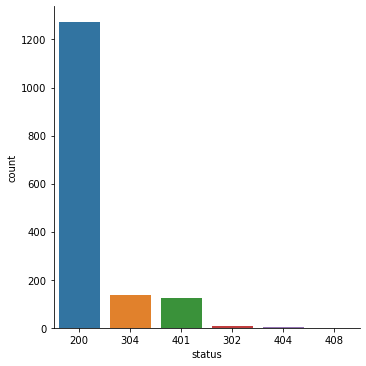

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

sns.catplot(x='status', y='count', data=status_freq_pd_df, 
            kind='bar', order=status_freq_pd_df['status'])

In [28]:
log_freq_df = status_freq_df.withColumn('log(count)', 
                                        F.log(status_freq_df['count']))
log_freq_df.show()

+------+-----+------------------+
|status|count|        log(count)|
+------+-----+------------------+
|   200| 1274| 7.149916836132109|
|   302|    6| 1.791759469228055|
|   304|  137| 4.919980925828125|
|   401|  123| 4.812184355372417|
|   404|    5|1.6094379124341003|
|   408|    1|               0.0|
+------+-----+------------------+



# handled the skewness from above

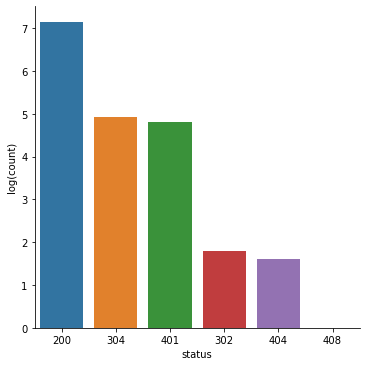

In [29]:
log_freq_pd_df = (log_freq_df
                    .toPandas()
                    .sort_values(by=['log(count)'],
                                 ascending=False))
sns.catplot(x='status', y='log(count)', data=log_freq_pd_df, 
            kind='bar', order=status_freq_pd_df['status'])

# Analyzing Frequent Hosts

In [30]:
host_sum_df =(logs_df
               .groupBy('host')
               .count()
               .sort('count', ascending=False).limit(10))

host_sum_df.show(truncate=False)

+-------------------------------+-----+
|host                           |count|
+-------------------------------+-----+
|64.242.88.10                   |452  |
|10.0.0.153                     |270  |
|h24-71-236-129.ca.shawcable.net|51   |
|cr020r01-3.sac.overture.com    |44   |
|h24-70-69-74.ca.shawcable.net  |32   |
|market-mail.panduit.com        |29   |
|ts04-ip92.hevanet.com          |28   |
|mail.geovariances.fr           |23   |
|ip68-228-43-49.tc.ph.cox.net   |22   |
|207.195.59.160                 |20   |
+-------------------------------+-----+



# Display the Top 20 Frequent EndPoints

In [31]:
paths_df = (logs_df
            .groupBy('endpoint')
            .count()
            .sort('count', ascending=False).limit(20))

paths_pd_df = paths_df.toPandas()
paths_pd_df 

,endpoint,count
0,/twiki/pub/TWiki/TWikiLogos/twikiRobot46x50.gif,64
1,/,47
2,/twiki/bin/view/Main/WebHome,41
3,/icons/gnu-head-tiny.jpg,37
4,/icons/PythonPowered.png,37
5,/icons/mailman.jpg,37
6,/favicon.ico,28
7,/robots.txt,27
8,/razor.html,26
9,/twiki/bin/view/Main/SpamAssassinTaggingOnly,18


# Top Ten Error Endpoints

In [32]:
not200_df = (logs_df
               .filter(logs_df['status'] != 200))

error_endpoints_freq_df = (not200_df
                               .groupBy('endpoint')
                               .count()
                               .sort('count', ascending=False)
                               .limit(10)
                          )
                          
error_endpoints_freq_df.show(truncate=False)  

+--------------------------------------------------------------+-----+
|endpoint                                                      |count|
+--------------------------------------------------------------+-----+
|/twiki/pub/TWiki/TWikiLogos/twikiRobot46x50.gif               |32   |
|/icons/PythonPowered.png                                      |26   |
|/icons/gnu-head-tiny.jpg                                      |26   |
|/icons/mailman.jpg                                            |26   |
|/                                                             |16   |
|/mailman                                                      |6    |
|/dccstats/index.html                                          |5    |
|/razor.html                                                   |3    |
|/twiki/bin/edit/Main/UvscanAndPostFix?topicparent=Main.WebHome|2    |
|/twiki/bin/edit/Main/PostConf?topicparent=Main.PostfixCommands|2    |
+--------------------------------------------------------------+-----+



# Total number of Unique Hosts

In [33]:
unique_host_count = (logs_df
                     .select('host')
                     .distinct()
                     .count())
unique_host_count

172

# Counting 404 Response Codes

In [35]:
not_found_df = logs_df.filter(logs_df["status"] == 404).cache()
print(('Total 404 responses: {}').format(not_found_df.count()))

Total 404 responses: 5


# Listing the Top Twenty 404 Response Code Endpoints

In [36]:
endpoints_404_count_df = (not_found_df
                          .groupBy("endpoint")
                          .count()
                          .sort("count", ascending=False)
                          .limit(20))

endpoints_404_count_df.show(truncate=False)

+-------------------------------------------------------------+-----+
|endpoint                                                     |count|
+-------------------------------------------------------------+-----+
|/MSOffice/cltreq.asp?UL=1&ACT=4&BUILD=2614&STRMVER=4&CAPREQ=0|1    |
|/M83A                                                        |1    |
|/pipermail/cipg/2003-november.txt                            |1    |
|/_vti_bin/owssvr.dll?UL=1&ACT=4&BUILD=2614&STRMVER=4&CAPREQ=0|1    |
|/twiki/view/Main/WebHome                                     |1    |
+-------------------------------------------------------------+-----+



# Listing the Top Twenty 404 Response Code Hosts

In [37]:
hosts_404_count_df = (not_found_df
                          .groupBy("host")
                          .count()
                          .sort("count", ascending=False)
                          .limit(20))

hosts_404_count_df.show(truncate=False)

+-----------------------------+-----+
|host                         |count|
+-----------------------------+-----+
|61.9.4.61                    |2    |
|1513.cps.virtua.com.br       |1    |
|osdlab.eic.nctu.edu.tw       |1    |
|h24-70-56-49.ca.shawcable.net|1    |
+-----------------------------+-----+

